In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow
import random

# Set random seed for reproducibility
np.random.seed(0)
tensorflow.random.set_seed(0)
random.seed(0)


In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load and preprocess the data
df = pd.read_csv('/content/drive/MyDrive/seema/2nd_data.csv')
df.head()

,Tweet,True Label,Sub,sub_labels
0,هذا تاريخ الخبيث اللي تروجله ياوهمي متطرف اخون...,1,P-HS,0
1,في نتألم جميعا كيف اصبح حال الشعب اليمني المظل...,1,P-HS,0
2,من كان يتوقع أن السعودية التي كانت تعاقب من يف...,1,R-HS,1
3,لن نجد اخس واذل من مان يستهدفون المدنيين ويقتل...,1,S-HS,2
4,إمعة وغبي وكذاب صفات الرئيس المنتدب الفطرية,1,P-HS,0


### **Preprocessing**

In [6]:
X = df['Tweet'].astype(str)
y = df['sub_labels']

In [7]:
from tensorflow.keras.utils import to_categorical
# Convert integer labels to one-hot encoded vectors
y_cat = to_categorical(y, num_classes=3)

### **Tokenization and padding**

In [8]:
max_words = 10000  # Max number of words in tokenizer
max_len = 62  # Max sequence length
embed_dim = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

### **Word Embedding Matrix**

In [9]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz; gunzip cc.ar.300.vec.gz

--2024-05-11 16:15:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  45.6MB/s    in 25s     

2024-05-11 16:15:30 (47.8 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [10]:
# Step 1: Load FastText Model
import gensim
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format('/content/cc.ar.300.vec', binary=False)

In [11]:
# Step 2: Create Embedding Matrix from FastText
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # FastText vectors are 300-dimensional
for word, i in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_vector = fasttext_model[word]
        embedding_matrix[i] = embedding_vector

### **Models**

In [12]:
# Define a list of deep learning models to experiment with
models = [

    ('GRU', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        GRU(128, kernel_initializer='glorot_uniform'),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])),
      ('RNN', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        SimpleRNN(128),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])),

    ('LSTM', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(128,  kernel_initializer='glorot_uniform'),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])),
    ('BiLSTM', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Bidirectional(LSTM(128,  kernel_initializer='glorot_uniform' )),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])),
    ('CNN', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Conv1D(128, 5, activation='relu',
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                bias_initializer=RandomNormal(mean=0.0, stddev=0.05)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ]))

]


### **Train 10 cross validation**

In [13]:
!export TF_DETERMINISTIC_OPS=1


In [14]:
# Stratified cross-validation with 10 folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'history'])

output_dir = '/content/drive/MyDrive/seema'
# Training and evaluation loop for each model
for name, model in models:
    print(f'Training and evaluating {name} with {n_splits}-fold stratified cross-validation...')
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_pad, y), 1):
        X_train, X_val = X_pad[train_idx], X_pad[val_idx]
        y_train, y_val = y_cat[train_idx], y_cat[val_idx]
        y_val_ =  y[val_idx]

        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

        # Define callbacks (checkpoint and early stopping)
        checkpoint = ModelCheckpoint(f'{output_dir}/checkpoints/{name}_fold{fold_idx}.h5', monitor='val_loss', save_best_only=True, verbose=0)
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

        # Train the model with callbacks
        history = model.fit(X_train, y_train, epochs=150, batch_size=128,
                            validation_data=(X_val, y_val),
                            callbacks=[checkpoint, early_stopping],
                            verbose=0)

        # Load the best model for prediction
        best_model = load_model(f'{output_dir}/checkpoints/{name}_fold{fold_idx}.h5')

        # Evaluate the model on the validation set
        probs = best_model.predict(X_val)
        y_pred = np.argmax(probs, axis=1)
        accuracy = accuracy_score(y_val_, y_pred)
        precision = precision_score(y_val_, y_pred,average='macro')
        recall = recall_score(y_val_, y_pred,average='macro')
        f1 = f1_score(y_val_, y_pred,average='macro')

        # Store the results for this fold
        fold_results.append([name, fold_idx, accuracy, precision, recall, f1, history.history])

    # Append fold results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(fold_results, columns=results_df.columns)],
                           ignore_index=True)


    # Calculate average metrics across all folds for this model
    avg_accuracy = np.mean(results_df[results_df['Model'] == name]['Accuracy'])
    avg_precision = np.mean(results_df[results_df['Model'] == name]['Precision'])
    avg_recall = np.mean(results_df[results_df['Model'] == name]['Recall'])
    avg_f1 = np.mean(results_df[results_df['Model'] == name]['F1 Score'])

    print(f'Average metrics for {name}:')
    print(f'Average Accuracy: {avg_accuracy:.4f}')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')
    print(f'Average F1 Score: {avg_f1:.4f}')
    print('')

# Save results to a CSV file
results_df.to_csv(f'{output_dir}/results/2nd_non_trainable_rnn_model_results_all.csv', index=False)

Training and evaluating GRU with 5-fold stratified cross-validation...
28/28 [==============================] - 3s 73ms/step
Average metrics for GRU:
Average Accuracy: 0.5277
Average Precision: 0.5477
Average Recall: 0.5784
Average F1 Score: 0.5327

Training and evaluating RNN with 5-fold stratified cross-validation...
28/28 [==============================] - 1s 23ms/step
Average metrics for RNN:
Average Accuracy: 0.8039
Average Precision: 0.7952
Average Recall: 0.7935
Average F1 Score: 0.7938

Training and evaluating LSTM with 5-fold stratified cross-validation...
28/28 [==============================] - 3s 87ms/step
Average metrics for LSTM:
Average Accuracy: 0.8068
Average Precision: 0.8014
Average Recall: 0.8000
Average F1 Score: 0.8001

Training and evaluating BiLSTM with 5-fold stratified cross-validation...
28/28 [==============================] - 7s 196ms/step
Average metrics for BiLSTM:
Average Accuracy: 0.7806
Average Precision: 0.7700
Average Recall: 0.7705
Average F1 Score:

In [15]:
import pandas as pd
results_df = pd.read_csv('/content/drive/MyDrive/seema/results/2nd_non_trainable_rnn_model_results_all.csv')

In [16]:
results_df

,Model,Fold,Accuracy,Precision,Recall,F1 Score,history
0,GRU,1,0.512332,0.536275,0.557216,0.519936,"{'loss': [1.0942946672439575, 1.08096659183502..."
1,GRU,2,0.533632,0.561821,0.579730,0.557270,"{'loss': [0.7978666424751282, 0.79644334316253..."
2,GRU,3,0.524130,0.540449,0.574043,0.523476,"{'loss': [0.8013380169868469, 0.79210913181304..."
3,GRU,4,0.533109,0.547380,0.591359,0.528088,"{'loss': [0.7998310923576355, 0.78995203971862..."
4,GRU,5,0.535354,0.552589,0.589712,0.534736,"{'loss': [0.8064727783203125, 0.79799860715866..."
5,RNN,1,0.748879,0.742103,0.722953,0.730570,"{'loss': [1.0967965126037598, 1.04223501682281..."
6,RNN,2,0.801570,0.791786,0.793515,0.792519,"{'loss': [0.5932168364524841, 0.57965147495269..."
7,RNN,3,0.824916,0.818550,0.824715,0.821527,"{'loss': [0.5837693214416504, 0.55676651000976..."
8,RNN,4,0.802469,0.784349,0.794869,0.788964,"{'loss': [0.5766492486000061, 0.55369961261749..."
9,RNN,5,0.841751,0.839256,0.831563,0.835253,"{'loss': [0.5811401009559631, 0.56020987033843..."


In [17]:
import ast

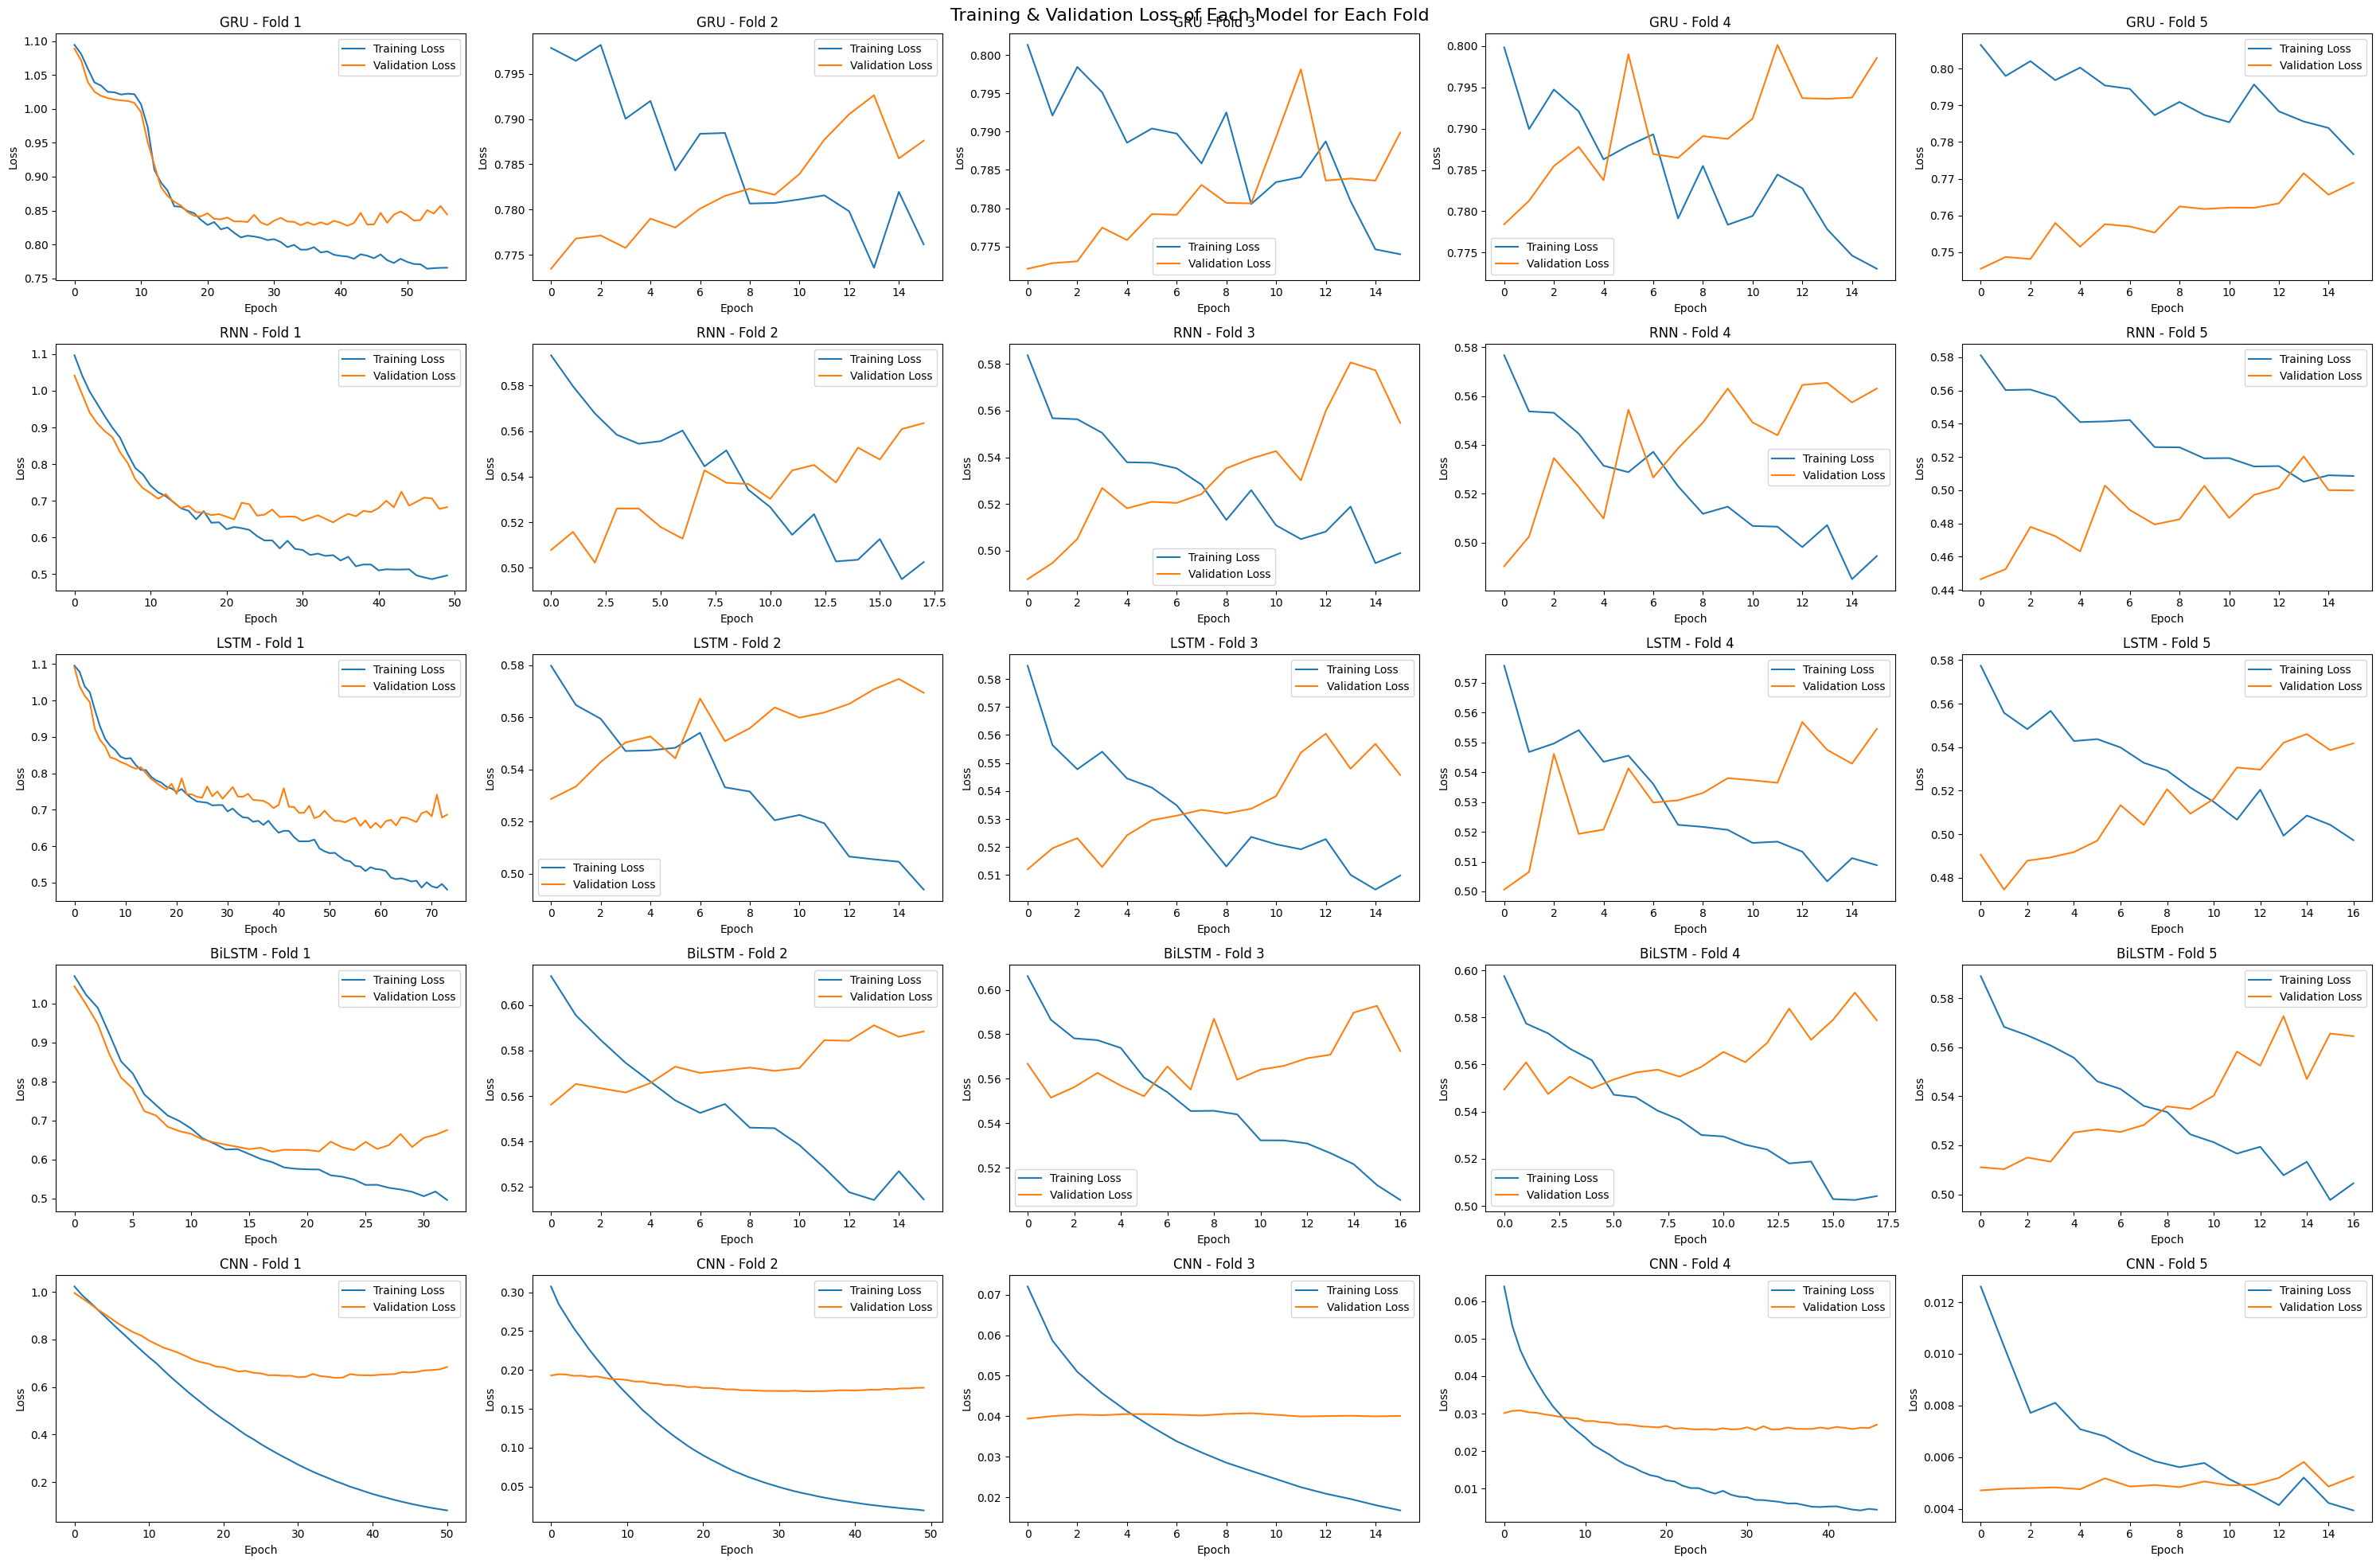

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of models and folds
num_models = len(results_df['Model'].unique())
num_folds = len(results_df['Fold'].unique())

# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(30, 4*num_models))
fig.suptitle('Training & Validation Loss of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[i, j].plot(history['loss'], label='Training Loss')
        axes[i, j].plot(history['val_loss'], label='Validation Loss')
        axes[i, j].set_title(f'{model} - Fold {fold}')
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].set_ylabel('Loss')
        axes[i, j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


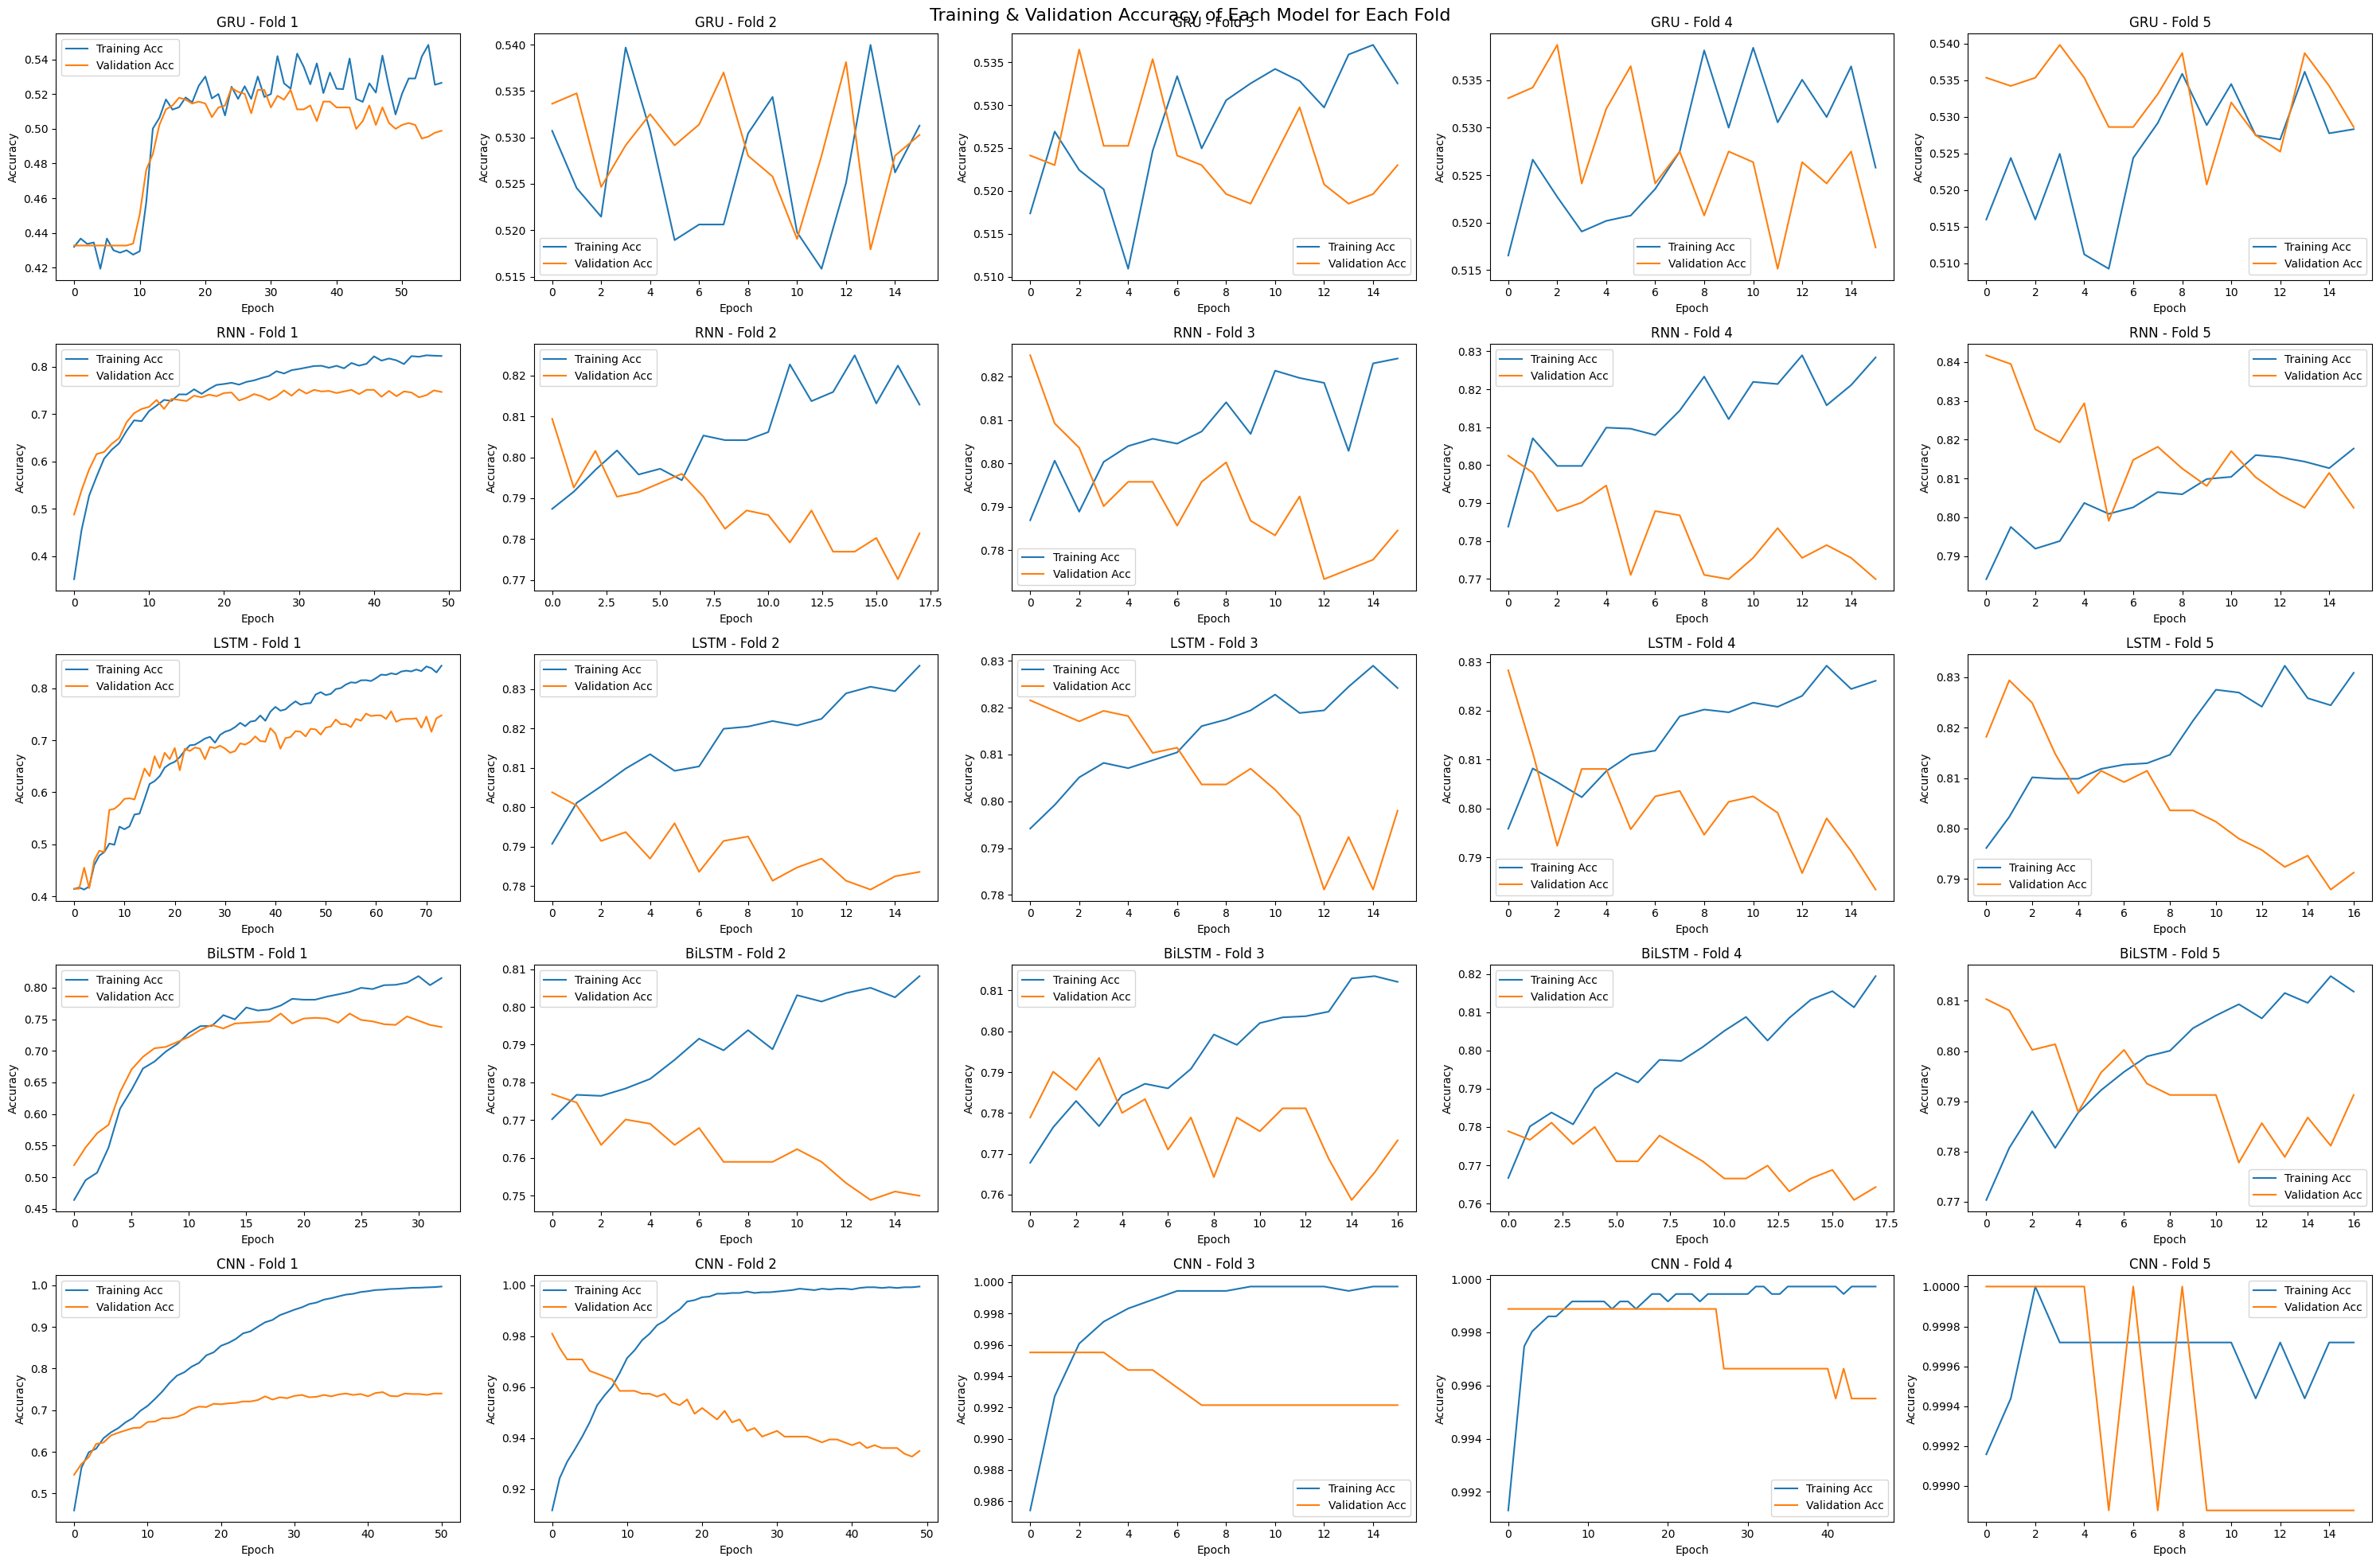

In [19]:
# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(30, 4*num_models))
fig.suptitle('Training & Validation Accuracy of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[i, j].plot(history['accuracy'], label='Training Acc')
        axes[i, j].plot(history['val_accuracy'], label='Validation Acc')
        axes[i, j].set_title(f'{model} - Fold {fold}')
        axes[i, j].set_xlabel('Epoch')
        axes[i, j].set_ylabel('Accuracy')
        axes[i, j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
